In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import pandas as pd
from global_model_periodic import LearnedSimulator_periodic
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')


In [ ]:
def compute_polygon_area_and_perimeter(polygon):
    polygon = np.array(polygon,dtype = np.float32)
    x = polygon[:, 0]
    y = polygon[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    perimeter = np.sum(np.linalg.norm(np.roll(polygon, -1, axis=0) - polygon, axis=1))
    return area, perimeter

def vornoi_area_and_perimeter(vor,target_indices):
    areas = []
    perimeters = []

    for idx in target_indices:
        region_index = vor.point_region[idx]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            areas.append(np.float32(1e-10))
            perimeters.append(np.float32(1e-10))
            continue
        polygon = [vor.vertices[i] for i in region]
        area, perimeter = compute_polygon_area_and_perimeter(polygon)
        areas.append(np.float32(area))
        perimeters.append(np.float32(perimeter)  )        
    return areas,perimeters

In [4]:
def loss_complete(acceleration, target):
    mse_loss = torch.nn.functional.mse_loss(acceleration, target)
    return mse_loss 

In [5]:
class TrajectoryDataset(Dataset):
    def __init__(self, csv_file_paths, step, seq_len=5, noise_std=0.0):
        self.samples = []
        self.seq_len = seq_len
        self.noise_std = noise_std

        for i in range(1,13):
            csvpath = csv_file_paths + str(i) + ".csv"
            df = pd.read_csv(
                csvpath,
                dtype={"x": np.float32, "y": np.float32, "step": np.int32, "site_index": np.int32}
            )
            

            df_grouped = df.groupby('step')
            clean_positions = []

            for step_id, data in df_grouped:
                if step_id < step:
                    data_sorted = data.sort_values('site_index')
                    np_data = data_sorted[['x', 'y']].to_numpy(dtype=np.float32)
                    pos = torch.from_numpy(np_data)
                    clean_positions.append(pos)

            for t in range(seq_len - 1, len(clean_positions)):
                input_seq = clean_positions[t - seq_len + 1: t + 1] 

                
                x_t2 = input_seq[-3]
                x_t1 = input_seq[-2]
                x_t = input_seq[-1]
                acc = x_t - 2*x_t1  + x_t2

                def noisy(x): 
                    return x + torch.randn_like(x) * self.noise_std if self.noise_std > 0 else x

                input_seq_noisy = torch.stack([noisy(x) for x in input_seq])
                self.samples.append((input_seq_noisy, acc))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [6]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float32).to(device)
    next_position, acc = model(x,n_cells)
    for i in range(len(pos)-1):
        pos[i] = pos[i+1].copy()
    pos[-1] = next_position.cpu().detach().numpy()
    return pos,acc

In [7]:
def avg_test(model,device,csv_file,n_cells):
    loss = 0
    csvpath = csv_file + str(13) +".csv" 
    df = pd.read_csv(csvpath)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions)
        vrai_pos.append(positions)
    for step in steps_list[5:200]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
            vrai_pos[i] = vrai_pos[i+1].copy() 
        vrai_pos[-1] = positions.copy()
        loss+=loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells]*1e3, dtype=torch.float).to(device)).item()
    return loss/195
        

In [8]:
def train_gnn_optimized(model, csv_files, loss_fn, epochs=11, lr=1e-4, batch_size=32, seq_len=5, noise_std=0.0, device='cuda'):
    model = model.to(device)
    model = torch.compile(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler(device=device)
    n_cells = 10
    print("Loading dataset...")
    start = time.perf_counter()
    dataset = TrajectoryDataset(csv_files, step=200, seq_len=seq_len, noise_std=noise_std)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded in {time.perf_counter() - start:.2f} seconds")
    
    model.train()
    train_loss = []
    test_loss = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_batches = 0
        for x_seq, acc in dataloader:
            x_seq = x_seq.to(device)
            acc = acc.to(device).squeeze(0)
            acc =acc[:n_cells]
            input_traj = x_seq.permute(0, 2, 1, 3).squeeze(0)
            optimizer.zero_grad()
            with autocast(device_type='cuda',enabled=False):
                output, pred_acc = model(input_traj,n_cells)
                loss = loss_fn(pred_acc, 1e3 * acc)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            total_batches += 1
        avg_loss = total_loss / total_batches if total_batches > 0 else 0
        

        if epoch % 5 == 0:
            model.eval()
            train_loss.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")
            test_l = avg_test(model, device, csv_files,n_cells)
            test_loss.append(test_l)
            print(f"Test Loss: {test_l:.6f}")
            model.train()
            print(1e3*acc,pred_acc)
            path_prefix = "//home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Training/acceleration_5Conv_256_5knn/"
            torch.save(model.state_dict(), path_prefix + f"model_{epoch}.pth")
            loss_df = pd.DataFrame({
                "epoch": list(range(len(train_loss))),
                "global_loss": train_loss,
                "test_loss": test_loss
            })
            loss_df.to_csv(path_prefix + f"loss_{epoch}.csv", index=False)

    return model, train_loss, test_loss


In [9]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)}
}

In [10]:
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device)
model.to(device)
trained_model, train_loss, test_loss = train_gnn_optimized(
    model=model,
    csv_files="/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_",
    loss_fn=loss_complete,
    epochs= 201,
    lr=1e-4,
    batch_size=1,
    seq_len=5,
    noise_std=0.0003,
    device='cuda'
)


Loading dataset...
Dataset loaded in 1.14 seconds


  0%|          | 0/201 [00:00<?, ?it/s]W0714 15:01:36.858000 225786 torch/_dynamo/convert_frame.py:964] [9/8] torch._dynamo hit config.recompile_limit (8)
W0714 15:01:36.858000 225786 torch/_dynamo/convert_frame.py:964] [9/8]    function: 'compute_polygon_area_and_perimeter' (/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Model/global_model_periodic.py:35)
W0714 15:01:36.858000 225786 torch/_dynamo/convert_frame.py:964] [9/8]    last reason: 9/4: len(polygon) == 4                                      
W0714 15:01:36.858000 225786 torch/_dynamo/convert_frame.py:964] [9/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0714 15:01:36.858000 225786 torch/_dynamo/convert_frame.py:964] [9/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Epoch 1/201, Avg Loss: 0.002544


  0%|          | 1/201 [01:26<4:46:42, 86.01s/it]

Test Loss: 0.002258
tensor([[ 0.0424,  0.0670],
        [ 0.0055,  0.0400],
        [ 0.0754, -0.0053],
        [-0.0370, -0.0296],
        [-0.0477, -0.0480],
        [-0.0404,  0.0080],
        [ 0.0533,  0.0244],
        [-0.0526,  0.0212],
        [ 0.0335, -0.0900],
        [-0.0324,  0.0122]], device='cuda:0') tensor([[-1.3044e-02, -1.0678e-02],
        [-2.4623e-02, -2.7354e-03],
        [ 1.0377e-02,  4.4841e-05],
        [ 2.7437e-03, -1.3045e-02],
        [-1.0016e-02, -1.0115e-02],
        [-8.9625e-03,  8.3921e-03],
        [ 2.2252e-03, -1.6770e-02],
        [-9.7665e-03,  1.5566e-02],
        [-6.1690e-04, -2.8397e-02],
        [ 7.8432e-03,  4.9684e-03]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


  2%|▏         | 5/201 [05:38<3:32:26, 65.03s/it]

Epoch 6/201, Avg Loss: 0.000966


  3%|▎         | 6/201 [06:45<3:34:18, 65.94s/it]

Test Loss: 0.002937
tensor([[ 0.0384, -0.0085],
        [-0.0260,  0.0378],
        [-0.0026, -0.0326],
        [ 0.0180,  0.0915],
        [-0.0182, -0.0030],
        [ 0.0430,  0.0161],
        [-0.0270, -0.0640],
        [-0.0262, -0.0083],
        [ 0.0089, -0.0333],
        [-0.0082,  0.0044]], device='cuda:0') tensor([[ 0.0223, -0.0109],
        [-0.0237,  0.0125],
        [ 0.0159, -0.0219],
        [-0.0006,  0.0572],
        [-0.0025, -0.0034],
        [ 0.0123,  0.0093],
        [-0.0266, -0.0561],
        [-0.0238, -0.0093],
        [-0.0073,  0.0099],
        [-0.0029,  0.0387]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


  5%|▍         | 10/201 [10:57<3:22:11, 63.52s/it]

Epoch 11/201, Avg Loss: 0.000328


  5%|▌         | 11/201 [12:04<3:25:05, 64.77s/it]

Test Loss: 0.003028
tensor([[-0.0608, -0.0417],
        [ 0.0785, -0.0869],
        [ 0.0361, -0.0298],
        [ 0.0845,  0.0298],
        [ 0.0420,  0.0398],
        [-0.0133,  0.0311],
        [-0.0091,  0.0517],
        [-0.0490, -0.0253],
        [-0.0457,  0.0667],
        [-0.0633, -0.0354]], device='cuda:0') tensor([[-0.0706, -0.0593],
        [ 0.0753, -0.1013],
        [ 0.0546, -0.0350],
        [ 0.0707,  0.0305],
        [ 0.0295,  0.0595],
        [-0.0350,  0.0201],
        [-0.0189,  0.0387],
        [-0.0655, -0.0153],
        [-0.0395,  0.0622],
        [-0.0605, -0.0229]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


  7%|▋         | 15/201 [16:16<3:16:35, 63.42s/it]

Epoch 16/201, Avg Loss: 0.000215


  8%|▊         | 16/201 [17:24<3:19:51, 64.82s/it]

Test Loss: 0.003270
tensor([[ 0.1508, -0.0073],
        [-0.0610,  0.1021],
        [ 0.0163,  0.0486],
        [-0.0878,  0.0142],
        [ 0.0136,  0.0130],
        [-0.0758,  0.0778],
        [-0.0487, -0.0516],
        [-0.0923, -0.0145],
        [ 0.0932, -0.1173],
        [ 0.0917, -0.0653]], device='cuda:0') tensor([[ 0.1429, -0.0158],
        [-0.0432,  0.0703],
        [ 0.0070,  0.0386],
        [-0.0804,  0.0232],
        [ 0.0213,  0.0049],
        [-0.0452,  0.0673],
        [-0.0546, -0.0366],
        [-0.0969, -0.0059],
        [ 0.1036, -0.1521],
        [ 0.0798, -0.0600]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 10%|▉         | 20/201 [21:36<3:10:52, 63.27s/it]

Epoch 21/201, Avg Loss: 0.000158


 10%|█         | 21/201 [22:44<3:14:20, 64.78s/it]

Test Loss: 0.002871
tensor([[ 0.0083,  0.0386],
        [ 0.0210, -0.0185],
        [-0.0226, -0.0374],
        [ 0.0104,  0.0477],
        [-0.0178,  0.0385],
        [ 0.0170,  0.0265],
        [ 0.0091, -0.0513],
        [-0.0226,  0.0140],
        [-0.0186, -0.0024],
        [ 0.0157, -0.0558]], device='cuda:0') tensor([[ 0.0216,  0.0313],
        [ 0.0270, -0.0204],
        [-0.0362, -0.0414],
        [ 0.0003,  0.0580],
        [-0.0253,  0.0495],
        [ 0.0253,  0.0369],
        [ 0.0069, -0.0565],
        [-0.0268,  0.0056],
        [-0.0128, -0.0101],
        [ 0.0071, -0.0537]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 12%|█▏        | 25/201 [26:57<3:06:42, 63.65s/it]

Epoch 26/201, Avg Loss: 0.000132


 13%|█▎        | 26/201 [28:04<3:08:19, 64.57s/it]

Test Loss: 0.002923
tensor([[-0.0858, -0.0264],
        [ 0.0706, -0.0596],
        [-0.0144, -0.0096],
        [-0.0420, -0.0365],
        [-0.0569,  0.0240],
        [ 0.0186, -0.0498],
        [-0.0059,  0.0373],
        [-0.0452,  0.0561],
        [ 0.1177,  0.0956],
        [ 0.0435, -0.0310]], device='cuda:0') tensor([[-0.0809, -0.0228],
        [ 0.0706, -0.0802],
        [ 0.0074, -0.0161],
        [-0.0362, -0.0217],
        [-0.0642,  0.0291],
        [ 0.0391, -0.0543],
        [-0.0159,  0.0233],
        [-0.0602,  0.0572],
        [ 0.1430,  0.1234],
        [ 0.0540, -0.0281]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 15%|█▍        | 30/201 [32:15<3:00:19, 63.27s/it]

Epoch 31/201, Avg Loss: 0.000114


 15%|█▌        | 31/201 [33:23<3:03:32, 64.78s/it]

Test Loss: 0.002937
tensor([[-0.0327, -0.0890],
        [-0.0472,  0.0494],
        [-0.0142,  0.1577],
        [-0.1948, -0.0641],
        [ 0.0916, -0.1219],
        [ 0.0192, -0.0891],
        [ 0.1758,  0.0624],
        [ 0.0865, -0.0374],
        [ 0.0004,  0.0026],
        [-0.0845,  0.1294]], device='cuda:0') tensor([[-0.0191, -0.0806],
        [-0.0410,  0.0417],
        [-0.0066,  0.1262],
        [-0.2051, -0.0691],
        [ 0.0867, -0.1158],
        [ 0.0099, -0.0959],
        [ 0.1720,  0.0595],
        [ 0.0887, -0.0506],
        [-0.0076,  0.0119],
        [-0.0761,  0.1308]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 17%|█▋        | 35/201 [37:39<2:56:49, 63.91s/it]

Epoch 36/201, Avg Loss: 0.000102


 18%|█▊        | 36/201 [38:48<3:00:27, 65.62s/it]

Test Loss: 0.002828
tensor([[-0.0172, -0.0434],
        [ 0.0349, -0.0759],
        [ 0.0082, -0.0632],
        [ 0.0369,  0.0488],
        [-0.0042,  0.0141],
        [ 0.0420, -0.0115],
        [-0.0715,  0.0575],
        [-0.0192,  0.0395],
        [ 0.0024,  0.0449],
        [-0.0122, -0.0105]], device='cuda:0') tensor([[-0.0111, -0.0426],
        [ 0.0319, -0.0749],
        [ 0.0097, -0.0487],
        [ 0.0291,  0.0488],
        [-0.0003,  0.0079],
        [ 0.0377, -0.0064],
        [-0.0678,  0.0504],
        [-0.0096,  0.0391],
        [ 0.0057,  0.0294],
        [-0.0134, -0.0088]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 20%|█▉        | 40/201 [43:00<2:49:47, 63.28s/it]

Epoch 41/201, Avg Loss: 0.000089


 20%|██        | 41/201 [44:08<2:52:56, 64.85s/it]

Test Loss: 0.002733
tensor([[ 0.1315, -0.0290],
        [-0.0620, -0.0254],
        [-0.0166,  0.0570],
        [-0.1178,  0.1179],
        [ 0.0169,  0.1040],
        [ 0.0827, -0.0233],
        [ 0.0151, -0.0975],
        [-0.0711, -0.1093],
        [ 0.0882,  0.0077],
        [-0.0668, -0.0024]], device='cuda:0') tensor([[ 0.1125, -0.0324],
        [-0.0636, -0.0346],
        [-0.0107,  0.0388],
        [-0.0852,  0.0811],
        [ 0.0235,  0.1044],
        [ 0.0679, -0.0353],
        [ 0.0274, -0.1023],
        [-0.0713, -0.1280],
        [ 0.0796,  0.0090],
        [-0.0588, -0.0044]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 22%|██▏       | 45/201 [48:18<2:43:26, 62.86s/it]

Epoch 46/201, Avg Loss: 0.000074


 23%|██▎       | 46/201 [49:25<2:45:19, 64.00s/it]

Test Loss: 0.002774
tensor([[-0.0253,  0.0449],
        [-0.0141,  0.0317],
        [ 0.0086,  0.0080],
        [-0.0425, -0.0804],
        [ 0.1025, -0.0225],
        [ 0.0015,  0.0968],
        [ 0.0588,  0.0342],
        [-0.0647, -0.0665],
        [-0.0627, -0.0121],
        [ 0.0379, -0.0341]], device='cuda:0') tensor([[-0.0313,  0.0404],
        [-0.0131,  0.0319],
        [ 0.0145,  0.0081],
        [-0.0468, -0.0791],
        [ 0.0912, -0.0167],
        [-0.0113,  0.0926],
        [ 0.0404,  0.0252],
        [-0.0556, -0.0509],
        [-0.0568, -0.0018],
        [ 0.0393, -0.0292]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 25%|██▍       | 50/201 [53:31<2:36:19, 62.12s/it]

Epoch 51/201, Avg Loss: 0.000072


 25%|██▌       | 51/201 [54:38<2:38:46, 63.51s/it]

Test Loss: 0.002755
tensor([[-0.0471, -0.0394],
        [-0.0285, -0.0422],
        [ 0.0436, -0.0352],
        [-0.0085,  0.0384],
        [ 0.0336, -0.0817],
        [ 0.0175,  0.0097],
        [-0.0012,  0.0788],
        [ 0.0057, -0.0184],
        [-0.0158,  0.0394],
        [ 0.0006,  0.0507]], device='cuda:0') tensor([[-3.3607e-02, -3.4096e-02],
        [-2.9863e-02, -3.9016e-02],
        [ 5.1785e-02, -3.3830e-02],
        [-6.6380e-03,  2.8550e-02],
        [ 3.4176e-02, -8.4547e-02],
        [ 1.2128e-02,  4.9665e-03],
        [ 1.3265e-05,  7.0785e-02],
        [ 1.0117e-02, -2.3126e-02],
        [-1.8611e-02,  4.0558e-02],
        [ 1.2136e-03,  4.7876e-02]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 27%|██▋       | 55/201 [58:51<2:33:44, 63.18s/it]

Epoch 56/201, Avg Loss: 0.000072


 28%|██▊       | 56/201 [59:57<2:34:59, 64.13s/it]

Test Loss: 0.002741
tensor([[ 0.0433, -0.0167],
        [ 0.0188,  0.0091],
        [-0.0357,  0.0526],
        [ 0.0113,  0.0139],
        [-0.0239,  0.0014],
        [-0.0219, -0.0612],
        [ 0.0380,  0.0306],
        [-0.0430, -0.0340],
        [ 0.0296, -0.0415],
        [-0.0166,  0.0458]], device='cuda:0') tensor([[ 0.0448, -0.0185],
        [ 0.0135,  0.0013],
        [-0.0306,  0.0515],
        [ 0.0105,  0.0047],
        [-0.0265, -0.0055],
        [-0.0208, -0.0695],
        [ 0.0405,  0.0179],
        [-0.0405, -0.0121],
        [ 0.0284, -0.0591],
        [-0.0249,  0.0462]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 30%|██▉       | 60/201 [1:04:05<2:26:21, 62.28s/it]

Epoch 61/201, Avg Loss: 0.000061


 30%|███       | 61/201 [1:05:11<2:28:29, 63.64s/it]

Test Loss: 0.002671
tensor([[ 0.0125,  0.1128],
        [-0.1082, -0.0094],
        [ 0.0624,  0.0311],
        [ 0.0793,  0.0973],
        [-0.0255, -0.1310],
        [-0.0343,  0.0699],
        [ 0.0667, -0.1703],
        [-0.0399, -0.0009],
        [-0.0497,  0.0831],
        [ 0.0369, -0.0828]], device='cuda:0') tensor([[ 0.0057,  0.1200],
        [-0.0990,  0.0037],
        [ 0.0568,  0.0360],
        [ 0.0680,  0.1048],
        [-0.0359, -0.1346],
        [-0.0424,  0.0644],
        [ 0.0561, -0.1747],
        [-0.0447,  0.0026],
        [-0.0629,  0.0756],
        [ 0.0369, -0.0838]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 32%|███▏      | 65/201 [1:09:27<2:24:07, 63.59s/it]

Epoch 66/201, Avg Loss: 0.000056


 33%|███▎      | 66/201 [1:10:35<2:26:04, 64.93s/it]

Test Loss: 0.002627
tensor([[ 0.1177, -0.0187],
        [-0.0139,  0.0373],
        [ 0.0145,  0.0762],
        [-0.0290, -0.0817],
        [-0.0179,  0.0664],
        [-0.0747, -0.0182],
        [-0.0116, -0.0340],
        [-0.0691,  0.0498],
        [ 0.0222, -0.0883],
        [ 0.0618,  0.0116]], device='cuda:0') tensor([[ 0.1264, -0.0131],
        [-0.0042,  0.0426],
        [ 0.0086,  0.0718],
        [-0.0278, -0.0853],
        [-0.0315,  0.0716],
        [-0.0757, -0.0378],
        [-0.0181, -0.0259],
        [-0.0746,  0.0551],
        [ 0.0214, -0.0952],
        [ 0.0690,  0.0085]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 35%|███▍      | 70/201 [1:14:48<2:18:12, 63.30s/it]

Epoch 71/201, Avg Loss: 0.000051


 35%|███▌      | 71/201 [1:15:54<2:19:22, 64.32s/it]

Test Loss: 0.002675
tensor([[ 0.1382, -0.0064],
        [-0.0413,  0.0705],
        [ 0.0119,  0.0608],
        [-0.0736, -0.0078],
        [ 0.0079,  0.0252],
        [-0.0751,  0.0587],
        [-0.0385, -0.0476],
        [-0.0939,  0.0054],
        [ 0.0787, -0.1121],
        [ 0.0859, -0.0466]], device='cuda:0') tensor([[ 0.1419, -0.0148],
        [-0.0484,  0.0700],
        [ 0.0042,  0.0490],
        [-0.0837, -0.0051],
        [ 0.0115,  0.0260],
        [-0.0756,  0.0688],
        [-0.0379, -0.0404],
        [-0.0947,  0.0011],
        [ 0.0813, -0.1120],
        [ 0.0919, -0.0594]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 37%|███▋      | 75/201 [1:20:03<2:11:49, 62.77s/it]

Epoch 76/201, Avg Loss: 0.000052


 38%|███▊      | 76/201 [1:21:10<2:13:14, 63.95s/it]

Test Loss: 0.002726
tensor([[-0.0170,  0.0233],
        [-0.0146, -0.0329],
        [ 0.0352, -0.0789],
        [-0.0578,  0.0564],
        [ 0.0507, -0.0380],
        [-0.0337, -0.0238],
        [-0.0251,  0.0195],
        [-0.0659, -0.0152],
        [ 0.0728,  0.0411],
        [ 0.0554,  0.0485]], device='cuda:0') tensor([[-0.0241,  0.0244],
        [-0.0177, -0.0242],
        [ 0.0451, -0.0793],
        [-0.0607,  0.0552],
        [ 0.0438, -0.0355],
        [-0.0327, -0.0178],
        [-0.0249,  0.0227],
        [-0.0709, -0.0136],
        [ 0.0681,  0.0531],
        [ 0.0592,  0.0545]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 40%|███▉      | 80/201 [1:25:17<2:05:28, 62.22s/it]

Epoch 81/201, Avg Loss: 0.000044


 40%|████      | 81/201 [1:26:23<2:07:00, 63.50s/it]

Test Loss: 0.002568
tensor([[ 0.0060,  0.0243],
        [ 0.0490,  0.0113],
        [ 0.0299,  0.0004],
        [-0.0765,  0.1207],
        [-0.0172, -0.0621],
        [-0.0544,  0.0663],
        [-0.1201, -0.0412],
        [-0.0531, -0.0936],
        [ 0.1416,  0.0547],
        [ 0.0948, -0.0805]], device='cuda:0') tensor([[ 0.0148,  0.0308],
        [ 0.0440, -0.0124],
        [ 0.0276, -0.0062],
        [-0.0822,  0.1076],
        [-0.0174, -0.0681],
        [-0.0438,  0.0597],
        [-0.1149, -0.0585],
        [-0.0515, -0.0933],
        [ 0.1381,  0.0515],
        [ 0.0983, -0.0795]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 42%|████▏     | 85/201 [1:30:30<1:59:57, 62.05s/it]

Epoch 86/201, Avg Loss: 0.000045


 43%|████▎     | 86/201 [1:31:37<2:01:43, 63.51s/it]

Test Loss: 0.002630
tensor([[-0.0147, -0.0010],
        [-0.1189,  0.0213],
        [-0.0238,  0.0127],
        [-0.0666, -0.0001],
        [ 0.1174, -0.0706],
        [-0.0006,  0.0023],
        [ 0.0710, -0.0370],
        [ 0.0226, -0.0037],
        [-0.0173,  0.0534],
        [ 0.0308,  0.0227]], device='cuda:0') tensor([[-1.5756e-02,  1.4043e-03],
        [-1.0206e-01,  1.6969e-02],
        [-1.7644e-02, -1.1340e-03],
        [-7.1215e-02,  1.0229e-03],
        [ 1.1190e-01, -7.2417e-02],
        [ 9.0407e-05,  3.1617e-03],
        [ 5.7761e-02, -4.1179e-02],
        [ 2.3821e-02, -3.3396e-03],
        [-1.9266e-02,  6.0881e-02],
        [ 3.1110e-02,  2.0704e-02]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 45%|████▍     | 90/201 [1:35:48<1:56:23, 62.92s/it]

Epoch 91/201, Avg Loss: 0.000042


 45%|████▌     | 91/201 [1:36:55<1:57:47, 64.25s/it]

Test Loss: 0.002675
tensor([[-0.0167,  0.0249],
        [-0.0169, -0.0376],
        [ 0.0345, -0.0816],
        [-0.0550,  0.0579],
        [ 0.0544, -0.0330],
        [-0.0337, -0.0273],
        [-0.0271,  0.0226],
        [-0.0656, -0.0173],
        [ 0.0728,  0.0378],
        [ 0.0530,  0.0536]], device='cuda:0') tensor([[-0.0152,  0.0276],
        [-0.0121, -0.0351],
        [ 0.0303, -0.0830],
        [-0.0514,  0.0603],
        [ 0.0519, -0.0356],
        [-0.0274, -0.0302],
        [-0.0227,  0.0226],
        [-0.0601, -0.0155],
        [ 0.0770,  0.0373],
        [ 0.0669,  0.0557]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 47%|████▋     | 95/201 [1:41:01<1:49:39, 62.07s/it]

Epoch 96/201, Avg Loss: 0.000039


 48%|████▊     | 96/201 [1:42:07<1:50:44, 63.28s/it]

Test Loss: 0.002642
tensor([[ 0.0405, -0.0124],
        [-0.0035,  0.0203],
        [-0.0590,  0.0222],
        [-0.0209,  0.0255],
        [-0.0208, -0.0101],
        [ 0.0059, -0.0230],
        [ 0.0831,  0.0457],
        [-0.0744, -0.0866],
        [ 0.0658, -0.0193],
        [-0.0169,  0.0380]], device='cuda:0') tensor([[ 0.0388, -0.0080],
        [-0.0065,  0.0185],
        [-0.0554,  0.0181],
        [-0.0219,  0.0282],
        [-0.0214, -0.0086],
        [ 0.0052, -0.0157],
        [ 0.0884,  0.0520],
        [-0.0675, -0.0897],
        [ 0.0747, -0.0151],
        [-0.0218,  0.0344]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 50%|████▉     | 100/201 [1:46:11<1:43:31, 61.50s/it]

Epoch 101/201, Avg Loss: 0.000039


 50%|█████     | 101/201 [1:47:16<1:44:28, 62.69s/it]

Test Loss: 0.002658
tensor([[ 0.0270,  0.0185],
        [ 0.0089,  0.0004],
        [ 0.0157,  0.0497],
        [-0.0193,  0.0279],
        [ 0.0192, -0.0792],
        [ 0.0007, -0.0347],
        [ 0.0686,  0.0581],
        [ 0.0256, -0.0880],
        [-0.0520, -0.0523],
        [-0.0943,  0.0997]], device='cuda:0') tensor([[ 0.0319,  0.0192],
        [ 0.0135,  0.0059],
        [ 0.0201,  0.0487],
        [-0.0092,  0.0276],
        [ 0.0129, -0.0708],
        [ 0.0074, -0.0346],
        [ 0.0621,  0.0500],
        [ 0.0298, -0.0962],
        [-0.0493, -0.0489],
        [-0.0960,  0.0993]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 52%|█████▏    | 105/201 [1:51:21<1:38:38, 61.65s/it]

Epoch 106/201, Avg Loss: 0.000040


 53%|█████▎    | 106/201 [1:52:27<1:39:33, 62.88s/it]

Test Loss: 0.002672
tensor([[ 0.1061, -0.0219],
        [-0.0085,  0.0275],
        [ 0.0147,  0.0759],
        [-0.0107, -0.0968],
        [-0.0235,  0.0788],
        [-0.0714, -0.0409],
        [-0.0141, -0.0279],
        [-0.0575,  0.0595],
        [ 0.0099, -0.0795],
        [ 0.0547,  0.0255]], device='cuda:0') tensor([[ 0.0991, -0.0219],
        [-0.0035,  0.0212],
        [ 0.0173,  0.0733],
        [-0.0045, -0.1045],
        [-0.0176,  0.0805],
        [-0.0630, -0.0514],
        [-0.0114, -0.0254],
        [-0.0514,  0.0608],
        [ 0.0123, -0.0794],
        [ 0.0472,  0.0246]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 55%|█████▍    | 110/201 [1:56:32<1:33:30, 61.65s/it]

Epoch 111/201, Avg Loss: 0.000036


 55%|█████▌    | 111/201 [1:57:38<1:34:30, 63.01s/it]

Test Loss: 0.002692
tensor([[ 0.0010,  0.0895],
        [-0.0824, -0.0102],
        [ 0.0364,  0.0205],
        [ 0.0659,  0.0855],
        [-0.0218, -0.1062],
        [-0.0280,  0.0498],
        [ 0.0597, -0.1427],
        [-0.0401, -0.0004],
        [-0.0333,  0.0656],
        [ 0.0427, -0.0513]], device='cuda:0') tensor([[ 0.0034,  0.0917],
        [-0.0837, -0.0086],
        [ 0.0442,  0.0280],
        [ 0.0839,  0.0988],
        [-0.0286, -0.1153],
        [-0.0245,  0.0510],
        [ 0.0590, -0.1439],
        [-0.0436,  0.0043],
        [-0.0305,  0.0665],
        [ 0.0368, -0.0473]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 57%|█████▋    | 115/201 [2:01:44<1:28:27, 61.72s/it]

Epoch 116/201, Avg Loss: 0.000035


 58%|█████▊    | 116/201 [2:02:50<1:29:28, 63.16s/it]

Test Loss: 0.002765
tensor([[ 0.0055,  0.0200],
        [-0.0095, -0.0130],
        [ 0.0772, -0.0076],
        [-0.0483, -0.0335],
        [ 0.0458,  0.0400],
        [-0.0107,  0.0011],
        [-0.0613, -0.0107],
        [ 0.0634,  0.0188],
        [-0.0773,  0.0115],
        [ 0.0152, -0.0268]], device='cuda:0') tensor([[ 0.0080,  0.0209],
        [-0.0075, -0.0135],
        [ 0.0808, -0.0069],
        [-0.0486, -0.0425],
        [ 0.0427,  0.0335],
        [-0.0158, -0.0029],
        [-0.0603, -0.0104],
        [ 0.0532,  0.0141],
        [-0.0774,  0.0136],
        [ 0.0109, -0.0297]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 60%|█████▉    | 120/201 [2:06:55<1:23:24, 61.78s/it]

Epoch 121/201, Avg Loss: 0.000034


 60%|██████    | 121/201 [2:08:02<1:24:15, 63.19s/it]

Test Loss: 0.002701
tensor([[-0.0147,  0.0150],
        [ 0.1161, -0.0116],
        [ 0.0158, -0.0439],
        [ 0.0157, -0.0160],
        [-0.0713,  0.0637],
        [ 0.0132,  0.0250],
        [-0.0355,  0.0150],
        [-0.0570,  0.0149],
        [ 0.0411, -0.0215],
        [-0.0236, -0.0403]], device='cuda:0') tensor([[-0.0208,  0.0190],
        [ 0.1248, -0.0124],
        [ 0.0182, -0.0402],
        [ 0.0112, -0.0154],
        [-0.0628,  0.0606],
        [ 0.0156,  0.0303],
        [-0.0354,  0.0103],
        [-0.0594,  0.0118],
        [ 0.0383, -0.0206],
        [-0.0181, -0.0424]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 62%|██████▏   | 125/201 [2:12:07<1:18:12, 61.75s/it]

Epoch 126/201, Avg Loss: 0.000031


 63%|██████▎   | 126/201 [2:13:13<1:18:51, 63.09s/it]

Test Loss: 0.002646
tensor([[ 0.1087, -0.0212],
        [-0.0095,  0.0294],
        [ 0.0148,  0.0761],
        [-0.0137, -0.0939],
        [-0.0225,  0.0764],
        [-0.0723, -0.0369],
        [-0.0136, -0.0290],
        [-0.0598,  0.0577],
        [ 0.0122, -0.0814],
        [ 0.0560,  0.0229]], device='cuda:0') tensor([[ 0.1108, -0.0223],
        [-0.0036,  0.0253],
        [ 0.0131,  0.0704],
        [-0.0148, -0.0888],
        [-0.0214,  0.0775],
        [-0.0559, -0.0322],
        [-0.0155, -0.0262],
        [-0.0549,  0.0568],
        [ 0.0140, -0.0872],
        [ 0.0701,  0.0217]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 65%|██████▍   | 130/201 [2:17:19<1:13:04, 61.76s/it]

Epoch 131/201, Avg Loss: 0.000031


 65%|██████▌   | 131/201 [2:18:25<1:13:33, 63.06s/it]

Test Loss: 0.002642
tensor([[ 0.0076, -0.0069],
        [-0.0241,  0.1054],
        [ 0.0513, -0.0372],
        [ 0.0622, -0.0227],
        [ 0.0582,  0.0655],
        [-0.0808, -0.0876],
        [-0.0559, -0.0025],
        [ 0.0528, -0.0277],
        [-0.0826, -0.0466],
        [ 0.0116,  0.0601]], device='cuda:0') tensor([[ 0.0121, -0.0058],
        [-0.0201,  0.0998],
        [ 0.0565, -0.0359],
        [ 0.0761, -0.0253],
        [ 0.0591,  0.0609],
        [-0.0741, -0.0807],
        [-0.0556, -0.0041],
        [ 0.0532, -0.0316],
        [-0.0733, -0.0461],
        [ 0.0153,  0.0622]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 67%|██████▋   | 135/201 [2:22:31<1:07:59, 61.81s/it]

Epoch 136/201, Avg Loss: 0.000034


 68%|██████▊   | 136/201 [2:23:37<1:08:23, 63.14s/it]

Test Loss: 0.002773
tensor([[-0.0516, -0.0535],
        [ 0.0732, -0.0776],
        [ 0.0160, -0.0426],
        [ 0.0808,  0.0398],
        [ 0.0193,  0.0230],
        [ 0.0185,  0.0149],
        [-0.0391,  0.0514],
        [-0.0440,  0.0070],
        [-0.0259,  0.0646],
        [-0.0474, -0.0275]], device='cuda:0') tensor([[-0.0502, -0.0526],
        [ 0.0777, -0.0865],
        [ 0.0209, -0.0370],
        [ 0.0807,  0.0442],
        [ 0.0189,  0.0308],
        [ 0.0130,  0.0206],
        [-0.0372,  0.0543],
        [-0.0428,  0.0063],
        [-0.0242,  0.0718],
        [-0.0543, -0.0279]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 70%|██████▉   | 140/201 [2:27:42<1:02:47, 61.77s/it]

Epoch 141/201, Avg Loss: 0.000028


 70%|███████   | 141/201 [2:28:48<1:03:03, 63.06s/it]

Test Loss: 0.002610
tensor([[ 0.0041,  0.0137],
        [ 0.1410, -0.0026],
        [ 0.0172, -0.0734],
        [ 0.0504, -0.0036],
        [-0.1168,  0.0789],
        [-0.0012,  0.0035],
        [-0.0594,  0.0215],
        [-0.0424,  0.0060],
        [ 0.0228, -0.0029],
        [-0.0153, -0.0414]], device='cuda:0') tensor([[ 0.0031,  0.0093],
        [ 0.1370, -0.0044],
        [ 0.0162, -0.0786],
        [ 0.0491, -0.0021],
        [-0.1151,  0.0777],
        [-0.0039,  0.0018],
        [-0.0591,  0.0204],
        [-0.0452,  0.0045],
        [ 0.0182, -0.0043],
        [-0.0160, -0.0381]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 72%|███████▏  | 145/201 [2:32:54<57:39, 61.79s/it]  

Epoch 146/201, Avg Loss: 0.000030


 73%|███████▎  | 146/201 [2:34:00<57:54, 63.17s/it]

Test Loss: 0.002648
tensor([[ 0.0383, -0.0125],
        [ 0.0354, -0.0146],
        [-0.0337,  0.0414],
        [ 0.0722, -0.0082],
        [ 0.0453,  0.0307],
        [-0.0592, -0.1422],
        [-0.0246,  0.0190],
        [ 0.0356, -0.0129],
        [-0.0665,  0.1027],
        [-0.0428, -0.0034]], device='cuda:0') tensor([[ 0.0346, -0.0116],
        [ 0.0400, -0.0094],
        [-0.0280,  0.0425],
        [ 0.0664, -0.0061],
        [ 0.0462,  0.0383],
        [-0.0593, -0.1443],
        [-0.0318,  0.0247],
        [ 0.0353, -0.0074],
        [-0.0581,  0.0979],
        [-0.0371,  0.0031]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 75%|███████▍  | 150/201 [2:38:06<52:33, 61.84s/it]

Epoch 151/201, Avg Loss: 0.000029


 75%|███████▌  | 151/201 [2:39:13<52:42, 63.24s/it]

Test Loss: 0.002679
tensor([[-0.0614, -0.0378],
        [ 0.0777, -0.0883],
        [ 0.0398, -0.0280],
        [ 0.0815,  0.0267],
        [ 0.0464,  0.0435],
        [-0.0205,  0.0332],
        [-0.0024,  0.0519],
        [-0.0487, -0.0309],
        [-0.0486,  0.0664],
        [-0.0640, -0.0365]], device='cuda:0') tensor([[-0.0620, -0.0345],
        [ 0.0717, -0.0900],
        [ 0.0292, -0.0378],
        [ 0.0836,  0.0309],
        [ 0.0411,  0.0421],
        [-0.0242,  0.0361],
        [-0.0009,  0.0477],
        [-0.0488, -0.0271],
        [-0.0542,  0.0768],
        [-0.0531, -0.0292]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 77%|███████▋  | 155/201 [2:43:17<47:19, 61.74s/it]

Epoch 156/201, Avg Loss: 0.000029


 78%|███████▊  | 156/201 [2:44:24<47:19, 63.10s/it]

Test Loss: 0.002659
tensor([[ 0.0487, -0.0628],
        [ 0.0099, -0.0527],
        [ 0.0091,  0.0614],
        [-0.0266,  0.0018],
        [ 0.0250, -0.0199],
        [-0.0210,  0.0508],
        [ 0.0340,  0.0312],
        [-0.0444,  0.0196],
        [-0.0492, -0.0596],
        [ 0.0144,  0.0302]], device='cuda:0') tensor([[ 0.0481, -0.0674],
        [ 0.0115, -0.0541],
        [ 0.0071,  0.0623],
        [-0.0260, -0.0015],
        [ 0.0349, -0.0216],
        [-0.0227,  0.0445],
        [ 0.0338,  0.0296],
        [-0.0454,  0.0180],
        [-0.0496, -0.0536],
        [ 0.0164,  0.0292]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 80%|███████▉  | 160/201 [2:48:29<42:13, 61.79s/it]

Epoch 161/201, Avg Loss: 0.000028


 80%|████████  | 161/201 [2:49:35<42:06, 63.16s/it]

Test Loss: 0.002722
tensor([[-0.0652, -0.0262],
        [-0.0386,  0.0294],
        [-0.0051,  0.0443],
        [ 0.0030, -0.0089],
        [ 0.0092,  0.0161],
        [ 0.0518, -0.0238],
        [-0.0229, -0.0290],
        [-0.0153, -0.0403],
        [ 0.0423,  0.0421],
        [ 0.0409, -0.0036]], device='cuda:0') tensor([[-0.0648, -0.0356],
        [-0.0386,  0.0334],
        [-0.0020,  0.0435],
        [-0.0033, -0.0099],
        [ 0.0067,  0.0146],
        [ 0.0521, -0.0273],
        [-0.0225, -0.0264],
        [-0.0188, -0.0401],
        [ 0.0420,  0.0348],
        [ 0.0402, -0.0080]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 82%|████████▏ | 165/201 [2:53:40<37:01, 61.70s/it]

Epoch 166/201, Avg Loss: 0.000027


 83%|████████▎ | 166/201 [2:54:46<36:44, 62.98s/it]

Test Loss: 0.002718
tensor([[-0.0284, -0.0169],
        [-0.0335,  0.0010],
        [ 0.0160, -0.0274],
        [-0.0017, -0.0170],
        [ 0.0157,  0.0288],
        [ 0.0005, -0.0172],
        [-0.0004,  0.0400],
        [ 0.0151, -0.0119],
        [ 0.0283, -0.0148],
        [-0.0117,  0.0353]], device='cuda:0') tensor([[-0.0280, -0.0206],
        [-0.0341, -0.0009],
        [ 0.0115, -0.0237],
        [-0.0011, -0.0162],
        [ 0.0136,  0.0291],
        [-0.0043, -0.0156],
        [ 0.0022,  0.0304],
        [ 0.0145, -0.0088],
        [ 0.0248, -0.0076],
        [-0.0094,  0.0304]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 85%|████████▍ | 170/201 [2:58:51<31:51, 61.65s/it]

Epoch 171/201, Avg Loss: 0.000024


 85%|████████▌ | 171/201 [2:59:57<31:30, 63.02s/it]

Test Loss: 0.002676
tensor([[-0.0074,  0.0266],
        [-0.0239, -0.0448],
        [ 0.0292, -0.0882],
        [-0.0356,  0.0570],
        [ 0.0694, -0.0095],
        [-0.0291, -0.0271],
        [-0.0361,  0.0294],
        [-0.0591, -0.0278],
        [ 0.0633,  0.0229],
        [ 0.0295,  0.0613]], device='cuda:0') tensor([[-0.0068,  0.0281],
        [-0.0248, -0.0423],
        [ 0.0275, -0.0893],
        [-0.0337,  0.0547],
        [ 0.0672, -0.0058],
        [-0.0296, -0.0230],
        [-0.0342,  0.0328],
        [-0.0588, -0.0235],
        [ 0.0690,  0.0279],
        [ 0.0288,  0.0633]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 87%|████████▋ | 175/201 [3:04:04<26:49, 61.91s/it]

Epoch 176/201, Avg Loss: 0.000026


 88%|████████▊ | 176/201 [3:05:10<26:20, 63.23s/it]

Test Loss: 0.002672
tensor([[-0.0825, -0.0223],
        [ 0.0650, -0.0688],
        [-0.0046, -0.0100],
        [-0.0362, -0.0368],
        [-0.0694,  0.0207],
        [ 0.0109, -0.0573],
        [-0.0064,  0.0350],
        [-0.0367,  0.0468],
        [ 0.1179,  0.1125],
        [ 0.0419, -0.0198]], device='cuda:0') tensor([[-0.0774, -0.0167],
        [ 0.0661, -0.0722],
        [ 0.0021, -0.0129],
        [-0.0317, -0.0347],
        [-0.0779,  0.0167],
        [ 0.0081, -0.0548],
        [-0.0100,  0.0301],
        [-0.0309,  0.0412],
        [ 0.1095,  0.1137],
        [ 0.0359, -0.0221]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 90%|████████▉ | 180/201 [3:09:15<21:35, 61.68s/it]

Epoch 181/201, Avg Loss: 0.000022


 90%|█████████ | 181/201 [3:10:21<21:01, 63.07s/it]

Test Loss: 0.002681
tensor([[ 0.0381, -0.0136],
        [ 0.0328, -0.0149],
        [-0.0331,  0.0436],
        [ 0.0699, -0.0083],
        [ 0.0463,  0.0293],
        [-0.0586, -0.1372],
        [-0.0255,  0.0193],
        [ 0.0335, -0.0134],
        [-0.0632,  0.0993],
        [-0.0401, -0.0041]], device='cuda:0') tensor([[ 0.0390, -0.0180],
        [ 0.0351, -0.0165],
        [-0.0303,  0.0339],
        [ 0.0658, -0.0133],
        [ 0.0432,  0.0234],
        [-0.0575, -0.1356],
        [-0.0220,  0.0190],
        [ 0.0417, -0.0164],
        [-0.0544,  0.0910],
        [-0.0332, -0.0037]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 92%|█████████▏| 185/201 [3:14:27<16:28, 61.77s/it]

Epoch 186/201, Avg Loss: 0.000022


 93%|█████████▎| 186/201 [3:15:33<15:47, 63.17s/it]

Test Loss: 0.002750
tensor([[-0.0484,  0.0986],
        [-0.0159, -0.0188],
        [-0.0899, -0.0834],
        [ 0.0196,  0.0038],
        [ 0.1081, -0.0018],
        [-0.0339, -0.0041],
        [ 0.0452,  0.0314],
        [ 0.0136, -0.0461],
        [-0.0265, -0.0160],
        [ 0.0283,  0.0362]], device='cuda:0') tensor([[-0.0518,  0.1004],
        [-0.0193, -0.0123],
        [-0.0931, -0.0830],
        [ 0.0157,  0.0085],
        [ 0.1072,  0.0004],
        [-0.0365, -0.0050],
        [ 0.0435,  0.0299],
        [ 0.0088, -0.0402],
        [-0.0282, -0.0147],
        [ 0.0230,  0.0393]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 95%|█████████▍| 190/201 [3:19:38<11:19, 61.79s/it]

Epoch 191/201, Avg Loss: 0.000022


 95%|█████████▌| 191/201 [3:20:45<10:32, 63.22s/it]

Test Loss: 0.002581
tensor([[ 0.0105, -0.0350],
        [-0.0070, -0.0833],
        [ 0.0055, -0.0517],
        [ 0.0064,  0.0510],
        [ 0.0071,  0.0204],
        [ 0.0398, -0.0268],
        [-0.0776,  0.0464],
        [-0.0007,  0.0558],
        [ 0.0170,  0.0194],
        [-0.0012,  0.0037]], device='cuda:0') tensor([[ 0.0113, -0.0350],
        [-0.0050, -0.0771],
        [ 0.0081, -0.0463],
        [ 0.0075,  0.0499],
        [ 0.0104,  0.0185],
        [ 0.0393, -0.0286],
        [-0.0733,  0.0430],
        [-0.0038,  0.0529],
        [ 0.0168,  0.0176],
        [ 0.0040,  0.0018]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 97%|█████████▋| 195/201 [3:24:49<06:09, 61.61s/it]

Epoch 196/201, Avg Loss: 0.000021


 98%|█████████▊| 196/201 [3:25:55<05:14, 62.97s/it]

Test Loss: 0.002649
tensor([[ 0.1300, -0.0153],
        [-0.0265,  0.0655],
        [ 0.0103,  0.0662],
        [-0.0647, -0.0259],
        [ 0.0004,  0.0344],
        [-0.0754,  0.0437],
        [-0.0305, -0.0450],
        [-0.0914,  0.0174],
        [ 0.0669, -0.1079],
        [ 0.0809, -0.0329]], device='cuda:0') tensor([[ 0.1310, -0.0156],
        [-0.0109,  0.0585],
        [ 0.0097,  0.0642],
        [-0.0540, -0.0274],
        [ 0.0022,  0.0374],
        [-0.0686,  0.0353],
        [-0.0221, -0.0497],
        [-0.0857,  0.0197],
        [ 0.0668, -0.1077],
        [ 0.0806, -0.0296]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


100%|█████████▉| 200/201 [3:30:00<01:01, 61.61s/it]

Epoch 201/201, Avg Loss: 0.000020


100%|██████████| 201/201 [3:31:06<00:00, 63.02s/it]

Test Loss: 0.002621
tensor([[-0.0476,  0.0719],
        [-0.0096, -0.0396],
        [-0.0846, -0.0274],
        [ 0.0136, -0.0149],
        [ 0.1027,  0.0075],
        [-0.0434, -0.0040],
        [ 0.0518,  0.0378],
        [ 0.0254, -0.0477],
        [-0.0341, -0.0141],
        [ 0.0259,  0.0306]], device='cuda:0') tensor([[-0.0485,  0.0740],
        [-0.0136, -0.0391],
        [-0.0869, -0.0203],
        [ 0.0079, -0.0165],
        [ 0.1077,  0.0062],
        [-0.0414, -0.0035],
        [ 0.0576,  0.0367],
        [ 0.0252, -0.0447],
        [-0.0345, -0.0109],
        [ 0.0246,  0.0318]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


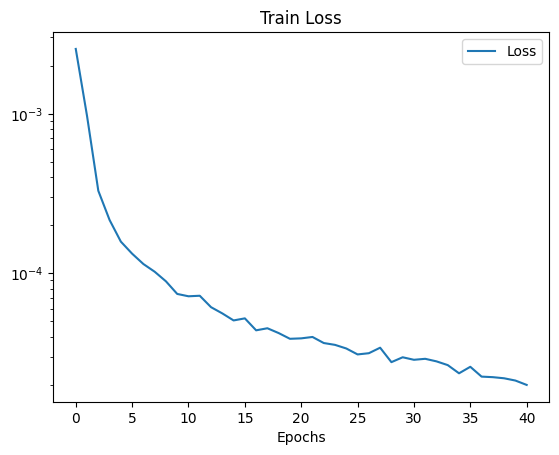

In [11]:
plt.plot(train_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Train Loss')
plt.show()

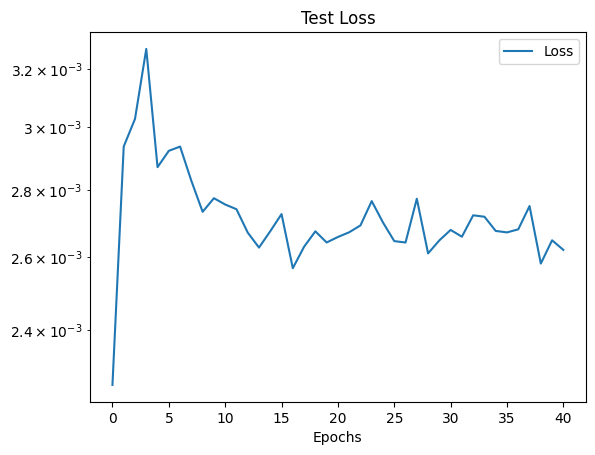

In [12]:
plt.plot(test_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Test Loss')
plt.show()

In [13]:
def create_csv_with_predictions(model,n_cells, device, input_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    norm_acc = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-vrai_pos[-2])[:n_cells]*1e3,pos[-1],vrai_pos[-1])
        if step%1==0:
            norm_acc.append(np.linalg.norm((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[0]))
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
    return loss,norm_acc

In [14]:
loss,acc = create_csv_with_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_13.csv",200)

tensor([[ 0.0255, -0.0012],
        [ 0.0166, -0.0122],
        [ 0.0080, -0.0665],
        [-0.0119,  0.0295],
        [-0.1012, -0.0867],
        [-0.0547, -0.0995],
        [ 0.0589,  0.1253],
        [ 0.0098, -0.0490],
        [ 0.0590,  0.1097],
        [ 0.0553,  0.0774]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 0.2168935   0.2751152 ]
 [ 0.4967934  -0.1993339 ]
 [-0.2094096  -1.2553578 ]
 [-0.0750348   0.2171239 ]
 [-1.8471895  -0.8772631 ]
 [-0.1262995  -0.6464906 ]
 [ 0.7410156   1.550648  ]
 [ 0.09524467 -0.2845044 ]
 [ 0.5045998   0.7923412 ]
 [ 0.2033863   0.4277214 ]] [[-0.02206123  0.10313121]
 [ 0.59667444  0.7845719 ]
 [-0.876621    0.9454875 ]
 [ 0.5959481  -0.2441662 ]
 [-0.7440918  -0.73984575]
 [ 0.21181217  0.78747165]
 [-0.75195044 -0.6390396 ]
 [-0.09129728 -0.76894516]
 [-0.4932125  -0.663257  ]
 [ 0.28790146 -0.24887508]
 [-0.02206123  2.1031315 ]
 [ 0.59667444  2.784572  ]
 [-0.876621    2.9454875 ]
 [ 0.5959481   1.7558337 ]
 [-0.7440918   1.2601541 ]


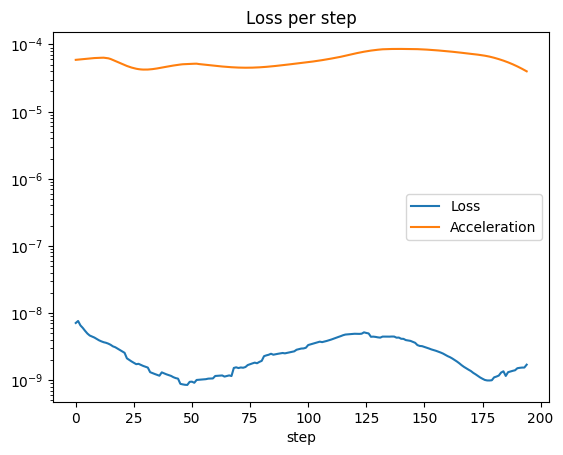

In [15]:
plt.plot(loss, label='Loss')
plt.plot(acc, label='Acceleration')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [16]:
def create_csv_with_real_predictions(model,n_cells, device, input_csv, output_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    results = []
    pos = []
    vrai_pos = []
    loss_fn = nn.MSELoss()
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells]*1e3)
        if step%1==0:
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
        for id_, positions in enumerate(pos[-1]):
                results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return loss

In [17]:
loss = create_csv_with_real_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_1.csv", "/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Training/acceleration_15Conv_256/computed_trajectories/computed_positions_1.csv",205)

tensor([[ 0.0063, -0.1478],
        [ 0.0340,  0.0552],
        [-0.0165,  0.0754],
        [-0.0653, -0.0314],
        [-0.0848, -0.3467],
        [ 0.0141, -0.0917],
        [ 0.0929,  0.1156],
        [ 0.0874,  0.1310],
        [-0.0062,  0.1706],
        [-0.0694,  0.1020]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 0.0054964  -0.1477537 ]
 [ 0.0245194   0.0594999 ]
 [-0.0140854   0.0531666 ]
 [-0.0713028  -0.0629378 ]
 [-0.06934    -0.3158328 ]
 [ 0.02080098 -0.0845132 ]
 [ 0.0833115   0.12146717]
 [ 0.093753    0.1331907 ]
 [-0.0061131   0.1541623 ]
 [-0.0670398   0.0895506 ]]
tensor([[ 0.0030, -0.1492],
        [ 0.0308,  0.0548],
        [-0.0196,  0.0692],
        [-0.0691, -0.0443],
        [-0.0876, -0.3447],
        [ 0.0185, -0.0885],
        [ 0.0929,  0.1174],
        [ 0.0850,  0.1324],
        [-0.0076,  0.1653],
        [-0.0668,  0.0996]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 0.0065728  -0.1464909 ]
 [ 0.0245782   0.0585137 ]
 [-0.0169271   0.0529463 ]


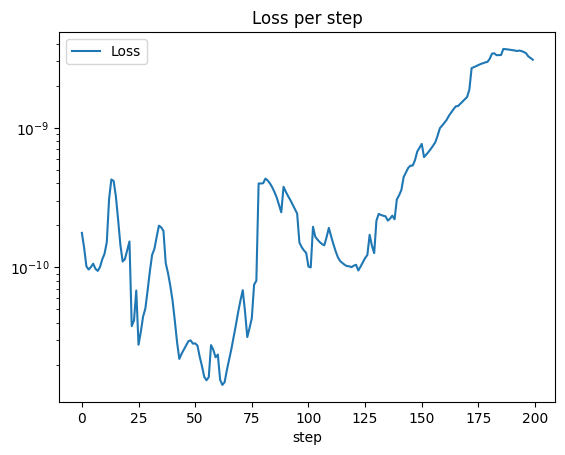

In [18]:
plt.plot(loss, label='Loss')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()